In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
basepath = os.path.expanduser('../')

pd.set_option('display.max_columns', None)

## Load Data

In [3]:
%%time

app_train = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/application_train.pkl'))
# app_test  = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/application_test.pkl'))

# # additional tables
# bureau       = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/bureau.pkl'))
# bureau_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/bureau_balance.pkl'))
prev_app     = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/previous_application.pkl'))
installments = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/installments_payments.pkl')) 
# pos_cash     = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/POS_CASH_balance.pkl'))
# credit_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/credit_card_balance.pkl'))

CPU times: user 191 ms, sys: 876 ms, total: 1.07 s
Wall time: 8.92 s


In [4]:
app_train.TARGET.value_counts(normalize=True)

0.0    0.919271
1.0    0.080729
Name: TARGET, dtype: float64

## EDA

In [6]:
print('Training data: {}'.format(app_train.shape))
# print('Test data: {}'.format(app_test.shape))

Training data: (307511, 122)


In [14]:
print('Bureau: {}'.format(bureau.shape))
print('Bureau Balance: {}'.format(bureau_bal.shape))
print('Credit Balance: {}'.format(credit_bal.shape))
print('Previous Applications: {}'.format(prev_app.shape))
print('Installments: {}'.format(installments.shape))
print('POS Cash: {}'.format(pos_cash.shape))

Bureau: (1716428, 17)
Bureau Balance: (27299925, 3)
Credit Balance: (3840312, 23)
Previous Applications: (1670214, 37)
Installments: (13605401, 8)
POS Cash: (10001358, 8)


In [5]:
app_train.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.014900,"Stone, brick",WEDNESDAY,0.972168,0.972168,0.972168,0.619141,0.624512,0.634277
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.071411,Block,MONDAY,0.984863,0.984863,0.984863,0.795898,0.798828,0.804199
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,WEDNESDAY,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,THURSDAY,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [8]:
bureau_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [9]:
credit_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.0,1800.0,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.0,2250.0,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,2250.0,2250.0,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,11925.0,11925.0,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,27000.0,27000.0,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [10]:
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182861,0.867188,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [12]:
pos_cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


## Take a positive and negative example

### Negative Example

In [5]:
app_train.loc[app_train.TARGET == 0, 'SK_ID_CURR'].sample(n=5)

175031    302830
244902    383477
135624    257305
174799    302568
87311     201331
Name: SK_ID_CURR, dtype: int32

#### Current Application

In [38]:
app_train.loc[app_train.SK_ID_CURR == 302830]

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
175031,7006.5,71955.0,67500.0,54000.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,F,NaN,NaN,NaN,-22454,365243,-4858,-175.0,-10656.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.668945,0.788574,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,N,N,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Cash loans,Secondary / secondary special,Widow,House / apartment,Pensioner,Unaccompanied,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,XNA,NaN,0.031342,2,2,0,0,0,0,302830,0.0,NaN,NaN,SUNDAY,NaN,NaN,NaN,NaN,NaN,NaN


#### Bureau

In [37]:
bureau.loc[bureau.SK_ID_CURR == 302830]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
394704,302830,6322441,Closed,currency 1,-1092,0,-483.0,-571.0,0.0,0,129574.078125,0.000000,0.000000,0.0,Consumer credit,-571,NaN
394705,302830,6322442,Active,currency 1,-1092,0,-404.0,NaN,0.0,0,0.000000,-2391.794922,2391.794922,0.0,Credit card,-605,NaN
394706,302830,6322444,Active,currency 1,-2713,0,-2520.0,NaN,NaN,0,11340.000000,2196.000000,0.000000,0.0,Consumer credit,-2535,NaN
394707,302830,6322445,Closed,currency 1,-1198,0,-1015.0,-1012.0,NaN,0,17770.500000,0.000000,0.000000,0.0,Consumer credit,-1012,NaN


#### Previous Application

In [6]:
prev_app.loc[prev_app.SK_ID_CURR == 383477].T

,159449
SK_ID_PREV,1448748
SK_ID_CURR,383477
NAME_CONTRACT_TYPE,Consumer loans
AMT_ANNUITY,25620.5
AMT_APPLICATION,678150
AMT_CREDIT,678150
AMT_DOWN_PAYMENT,0
AMT_GOODS_PRICE,678150
WEEKDAY_APPR_PROCESS_START,WEDNESDAY
HOUR_APPR_PROCESS_START,14


#### Credit Balance

In [27]:
credit_bal.loc[credit_bal.SK_ID_CURR == 302830].T

,640480,1187657,1350126,1506527,2280972
SK_ID_PREV,1564640,1564640,1564640,1564640,1564640
SK_ID_CURR,302830,302830,302830,302830,302830
MONTHS_BALANCE,-4,-6,-3,-2,-5
AMT_BALANCE,0,0,0,0,0
AMT_CREDIT_LIMIT_ACTUAL,180000,180000,180000,180000,180000
AMT_DRAWINGS_ATM_CURRENT,NaN,NaN,NaN,NaN,NaN
AMT_DRAWINGS_CURRENT,0,0,0,0,0
AMT_DRAWINGS_OTHER_CURRENT,NaN,NaN,NaN,NaN,NaN
AMT_DRAWINGS_POS_CURRENT,NaN,NaN,NaN,NaN,NaN
AMT_INST_MIN_REGULARITY,0,0,0,0,0


#### Pos Cash

In [29]:
pos_cash.loc[pos_cash.SK_ID_CURR == 302830].T

,108703,123700,494470,523004,1292733,1431723,1761331,1969691,2208647,2454966,2676410,2852019,3052605,3056327,3840797,4262251,4411068,4869811,5078856,5849753,5912482,7029457,7526641,7817971,7843956,7884120,8230425,8328639,8848272,9882687
SK_ID_PREV,1383648,1383648,2310176,2469663,1383648,2469663,2310176,1383648,2469663,2310176,2310176,2469663,2469663,2310176,1383648,2310176,2469663,2469663,2310176,2310176,2310176,2310176,2310176,2469663,2523662,2523662,2469663,2523662,2523662,2310176
SK_ID_CURR,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830
MONTHS_BALANCE,-2,-3,-92,-75,-4,-73,-87,-5,-72,-95,-94,-74,-78,-93,-6,-96,-77,-79,-91,-88,-89,-90,-86,-76,-61,-60,-80,-59,-58,-85
CNT_INSTALMENT,24,24,10,8,24,8,10,24,8,10,10,8,8,10,24,10,8,8,10,10,10,10,10,8,4,4,8,4,4,10
CNT_INSTALMENT_FUTURE,20,21,4,2,22,0,0,23,0,7,6,1,6,5,24,8,5,7,3,0,1,2,0,4,4,3,8,2,1,0
NAME_CONTRACT_STATUS,Active,Active,Active,Active,Active,Active,Active,Active,Completed,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Completed
SK_DPD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SK_DPD_DEF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Installments

In [32]:
installments.loc[installments.SK_ID_CURR == 302830].T.astype(np.int)

,7680241,7723599,7850852,7897054,8022912,8100569,8419004,8504819,8549533,8602856,8640197,8703960,8727131,9027402,9212442,9377238,10358847,10400643,10430895,10451237,10458376,10527755,10650605,11096064,11326433,11454944
SK_ID_PREV,2523662,2310176,2310176,2469663,1383648,2310176,1383648,2469663,2310176,2469663,2469663,2469663,2310176,2310176,2310176,2469663,1383648,2469663,2523662,2310176,1383648,2523662,2523662,2469663,1383648,2310176
SK_ID_CURR,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830,302830
NUM_INSTALMENT_VERSION,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1
NUM_INSTALMENT_NUMBER,2,4,8,3,4,5,2,5,2,6,8,1,10,9,7,7,1,2,4,3,3,3,1,4,5,6
DAYS_INSTALMENT,-1784,-2848,-2728,-2350,-55,-2818,-115,-2290,-2908,-2260,-2200,-2410,-2668,-2698,-2758,-2230,-145,-2380,-1724,-2878,-85,-1754,-1814,-2320,-25,-2788
DAYS_ENTRY_PAYMENT,-1815,-2860,-2732,-2350,-60,-2824,-123,-2290,-2920,-2260,-2208,-2410,-2668,-2698,-2762,-2230,-150,-2380,-1744,-2886,-92,-1786,-1836,-2320,-28,-2796
AMT_INSTALMENT,2788,1795,1795,4784,8440,1795,8440,4784,1795,4784,4773,4784,1777,1795,1795,4784,8440,4784,7976,1795,8440,2788,2788,4784,8440,1795
AMT_PAYMENT,2788,1795,1795,4784,8440,1795,8440,4784,1795,4784,4773,4784,1777,1795,1795,4784,8440,4784,7976,1795,8440,2788,2788,4784,8440,1795


### Positive Example

In [5]:
app_train.loc[app_train.TARGET == 1, 'SK_ID_CURR'].sample(n=5)

187028    316817
6153      107188
66569     177197
129070    249712
53110     161509
Name: SK_ID_CURR, dtype: int32

#### Current Application

In [33]:
app_train.loc[app_train.SK_ID_CURR == 316817]

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
187028,38686.5,755190.0,675000.0,382500.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,M,NaN,NaN,NaN,-16695,365243,-245,-1062.0,-1329.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.211426,0.515625,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,N,Y,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Cash loans,Secondary / secondary special,Married,House / apartment,Pensioner,Unaccompanied,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,XNA,NaN,0.016617,2,2,0,0,0,0,316817,1.0,NaN,NaN,WEDNESDAY,NaN,NaN,NaN,NaN,NaN,NaN


#### Bureau

In [34]:
bureau.loc[bureau.SK_ID_CURR == 316817]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1167018,316817,6198732,Active,currency 1,-713,0,1113.0,NaN,NaN,0,301500.0,218952.0,0.0,0.0,Consumer credit,-9,NaN
1167019,316817,6198733,Active,currency 1,-1057,0,770.0,NaN,NaN,0,1575000.0,580293.0,0.0,0.0,Consumer credit,-19,NaN
1167020,316817,6198734,Active,currency 1,-390,0,1436.0,NaN,25636.5,0,891000.0,NaN,NaN,0.0,Consumer credit,-23,NaN
1167021,316817,6198735,Active,currency 1,-165,0,1661.0,NaN,0.0,0,1350000.0,558085.5,0.0,0.0,Consumer credit,-24,NaN


#### Previous Application

In [7]:
prev_app.loc[prev_app.SK_ID_CURR == 107188].T

,1055600
SK_ID_PREV,1830238
SK_ID_CURR,107188
NAME_CONTRACT_TYPE,Consumer loans
AMT_ANNUITY,6513.12
AMT_APPLICATION,53190
AMT_CREDIT,59269.5
AMT_DOWN_PAYMENT,0
AMT_GOODS_PRICE,53190
WEEKDAY_APPR_PROCESS_START,TUESDAY
HOUR_APPR_PROCESS_START,19


#### Credit Balance

In [9]:
credit_bal.loc[credit_bal.SK_ID_CURR == 316817].T

""
SK_ID_PREV
SK_ID_CURR
MONTHS_BALANCE
AMT_BALANCE
AMT_CREDIT_LIMIT_ACTUAL
AMT_DRAWINGS_ATM_CURRENT
AMT_DRAWINGS_CURRENT
AMT_DRAWINGS_OTHER_CURRENT
AMT_DRAWINGS_POS_CURRENT
AMT_INST_MIN_REGULARITY


#### Pos Cash

In [10]:
pos_cash.loc[pos_cash.SK_ID_CURR == 316817].T

,65394,153943,447923,626081,711322,737494,975544,1139883,1792707,1808307,2017712,2044640,2140482,2516443,2680436,2759304,2772372,2926742,3056093,3184816,3508805,3849417,3930535,4085722,4191332,4461092,4579987,4675557,4921251,6166679,6419190,8333823,8805029,9018057,9022499,9233670,9503030
SK_ID_PREV,1374526,1374526,2272653,2272654,2272654,1374526,2272653,1374526,2396890,1374526,2396890,2272654,1374526,2523641,2272654,2523641,2396890,2272653,1374526,2272654,2272653,2396890,1374526,1374526,2396890,2396890,2272654,2272653,2396890,2272653,1374526,2396890,2272654,2272653,2272653,2272653,2272653
SK_ID_CURR,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817
MONTHS_BALANCE,-12,-13,-38,-21,-25,-16,-42,-14,-25,-20,-26,-23,-17,-96,-26,-95,-28,-36,-21,-22,-35,-31,-15,-19,-27,-30,-27,-34,-29,-33,-18,-24,-24,-37,-40,-41,-39
CNT_INSTALMENT,10,48,12,7,43,48,12,48,48,48,48,43,48,10,42,10,48,12,48,43,12,48,48,48,48,48,42,12,48,9,48,7,43,12,12,12,12
CNT_INSTALMENT_FUTURE,0,39,8,0,41,42,12,40,42,46,43,38,43,1,41,0,45,6,47,37,5,48,41,45,44,47,42,4,46,0,44,0,39,7,10,11,9
NAME_CONTRACT_STATUS,Completed,Active,Active,Completed,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Completed,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Completed,Active,Completed,Active,Active,Active,Active,Active
SK_DPD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SK_DPD_DEF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Installments

In [11]:
installments.loc[installments.SK_ID_CURR == 316817].T.astype(np.int)

,8095356,8121327,8231954,8256851,8304019,8369975,8472548,8721788,8769585,8921775,9176410,9228705,9346982,9348192,9368436,9371603,9439386,9530584,9733445,9785675,9835203,9997020,10035736,10181633,10202980,10227911,10523812,10549649,10574099,10810943,10827894,11078247,11110067,11222015,11222016,11243587
SK_ID_PREV,1374526,2272653,1374526,2272653,2272653,2272654,1374526,2396890,2396890,2523641,2272653,2396890,2272653,1374526,2396890,1374526,2272653,2272653,1374526,2272653,2272654,1374526,2272654,2396890,1374526,2396890,2272654,2272654,1374526,2272654,1374526,2272653,2272654,2396890,2396890,1374526
SK_ID_CURR,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817,316817
NUM_INSTALMENT_VERSION,1,1,1,1,1,1,2,3,1,1,2,1,1,1,4,1,1,1,1,1,3,1,2,1,1,1,2,2,1,1,1,1,1,1,2,1
NUM_INSTALMENT_NUMBER,8,1,7,2,4,3,10,6,4,10,9,1,8,6,7,3,3,7,4,6,7,9,5,2,5,3,4,6,9,1,1,5,2,5,5,2
DAYS_INSTALMENT,-423,-1267,-453,-1237,-1177,-731,-363,-776,-836,-2912,-1027,-926,-1057,-483,-746,-573,-1207,-1087,-543,-1117,-638,-393,-698,-896,-513,-866,-728,-668,-393,-791,-633,-1147,-761,-806,-806,-603
DAYS_ENTRY_PAYMENT,-425,-1279,-453,-1250,-1197,-739,-389,-781,-849,-2938,-1055,-956,-1079,-485,-750,-572,-1223,-1104,-550,-1138,-655,-425,-739,-914,-515,-877,-739,-690,-389,-788,-634,-1166,-760,-819,-819,-606
AMT_INSTALMENT,37339,22900,37339,22900,22900,33510,741767,7781,24782,2595,83822,24782,22900,37339,192691,37339,22900,22900,37339,22900,614025,37339,33516,24782,37339,24782,3144,33516,37339,33510,37339,22900,33510,24782,413760,37339
AMT_PAYMENT,37339,22900,37339,22900,22900,33510,741767,7781,24782,2595,83822,24782,22900,37339,192691,37339,22900,22900,37339,22900,614025,87,33516,24782,37339,24782,3144,33516,37251,33510,37339,22900,33510,438543,438543,37339


#### Distribution of Contract Status of all previous applications of loanee

In [13]:
f = app_train.loc[app_train.TARGET == 0, ['SK_ID_CURR']]\
         .merge(prev_app.loc[:, ['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_STATUS']],
                how='left'
               ); f.head()

,SK_ID_CURR,SK_ID_PREV,NAME_CONTRACT_STATUS
0,100003,1810518.0,Approved
1,100003,2636178.0,Approved
2,100003,2396755.0,Approved
3,100004,1564014.0,Approved
4,100006,2078043.0,Approved


In [19]:
t1 = f.groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].nunique()

In [16]:
t = app_train.loc[app_train.TARGET == 1, ['SK_ID_CURR']]\
         .merge(prev_app.loc[:, ['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_STATUS']],
                how='left'
               ); t.head()

,SK_ID_CURR,SK_ID_PREV,NAME_CONTRACT_STATUS
0,100002,1038818.0,Approved
1,100031,NaN,NaN
2,100047,1472630.0,Approved
3,100047,2426800.0,Approved
4,100047,1021215.0,Refused


In [20]:
t2 = t.groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].nunique()

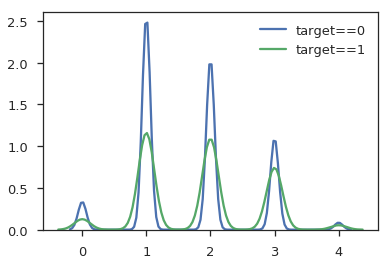

In [22]:
sns.kdeplot(t1, label='target==0')
sns.kdeplot(t2, label='target==1')

In [26]:
t1 = f.groupby(['SK_ID_CURR', 'NAME_CONTRACT_STATUS']).size().unstack().fillna(0)

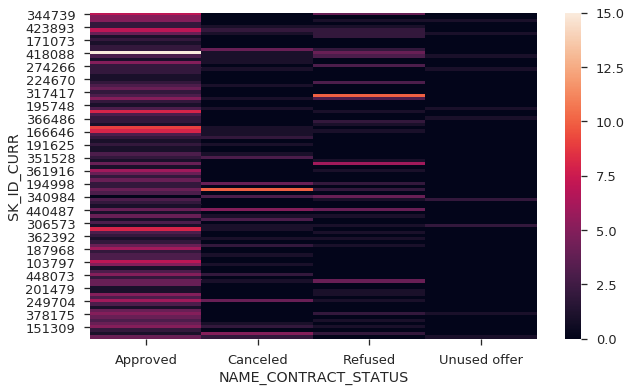

In [31]:
plt.figure(figsize=(10, 6))
sns.heatmap(t1.sample(n=100));

In [29]:
t2 = t.groupby(['SK_ID_CURR', 'NAME_CONTRACT_STATUS']).size().unstack().fillna(0)

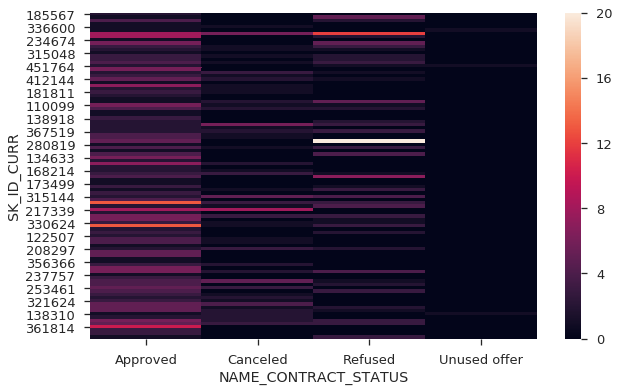

In [32]:
plt.figure(figsize=(10, 6))
sns.heatmap(t2.sample(n=100));

#### Relationship between AMT CREDIT and CNT PAYMENT for previous applications

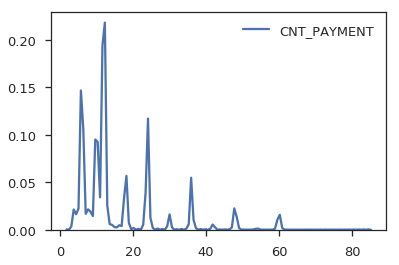

In [82]:
sns.kdeplot(prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved') &\
                   (prev_app.CNT_PAYMENT > 0), 'CNT_PAYMENT']);

In [65]:
# TODO: implement feature in the pipeline
tmp = prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved') &\
                   (prev_app.CNT_PAYMENT > 0)
                   , ['SK_ID_CURR',
                      'AMT_CREDIT',
                      'AMT_ANNUITY',
                      'CNT_PAYMENT'
                     ]]

tmp.loc[:, 'per_month_annuity'] = tmp.AMT_CREDIT / tmp.CNT_PAYMENT
tmp.loc[:, 'diff_annuity']      = tmp.AMT_ANNUITY - tmp.per_month_annuity
tmp.loc[:, 'ratio_annuity']     = tmp.AMT_ANNUITY / tmp.per_month_annuity
tmp.head()

,SK_ID_CURR,AMT_CREDIT,AMT_ANNUITY,CNT_PAYMENT,per_month_annuity,diff_annuity,ratio_annuity
0,271877,17145.0,1730.430054,12.0,1428.750,301.680054,1.211150
1,108129,679671.0,25188.615234,36.0,18879.750,6308.865234,1.334160
2,122040,136444.5,15060.735352,12.0,11370.375,3690.360352,1.324559
3,176158,470790.0,47041.335938,12.0,39232.500,7808.835938,1.199040
5,199383,340573.5,23703.929688,18.0,18920.750,4783.179688,1.252801


In [66]:
res = tmp.groupby('SK_ID_CURR')['per_month_annuity'].mean()
res = app_train.SK_ID_CURR.map(res)

print(res[res.isnull()].shape[0] / len(res))

0.065285469462881


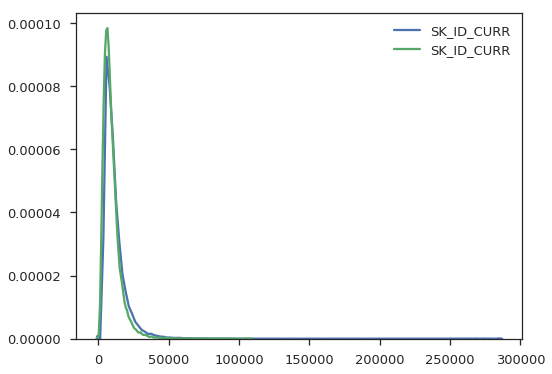

In [67]:
plt.figure(figsize=(8, 6))
sns.kdeplot(res[app_train.TARGET == 0])
sns.kdeplot(res[app_train.TARGET == 1]);

In [79]:
res = tmp.groupby('SK_ID_CURR')['ratio_annuity'].median()
res = app_train.SK_ID_CURR.map(res)

print(res[res.isnull()].shape[0] / len(res))

0.06529197329526423


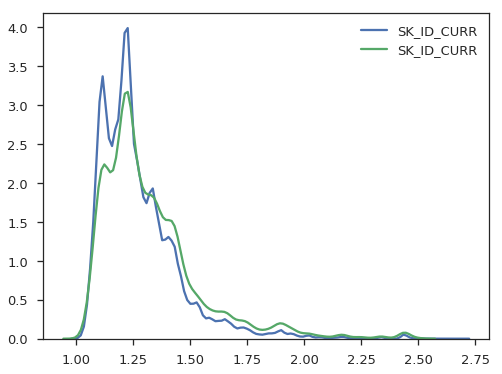

In [80]:
plt.figure(figsize=(8, 6))
sns.kdeplot(res[app_train.TARGET == 0])
sns.kdeplot(res[app_train.TARGET == 1]);

#### Relationship of ratio annuity and days decision

In [84]:
tmp = prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved') &\
                   (prev_app.CNT_PAYMENT > 0)
                   , ['SK_ID_CURR',
                      'AMT_CREDIT',
                      'AMT_ANNUITY',
                      'CNT_PAYMENT',
                      'DAYS_DECISION'
                     ]]

tmp.loc[:, 'per_month_annuity'] = tmp.AMT_CREDIT / tmp.CNT_PAYMENT
tmp.loc[:, 'diff_annuity']      = tmp.AMT_ANNUITY - tmp.per_month_annuity
tmp.loc[:, 'ratio_annuity']     = tmp.AMT_ANNUITY / tmp.per_month_annuity
tmp.loc[:, 'mult_ratio_annuity_days_decision'] = tmp.ratio_annuity * (-tmp.DAYS_DECISION / 365)

tmp.head()

,SK_ID_CURR,AMT_CREDIT,AMT_ANNUITY,CNT_PAYMENT,DAYS_DECISION,per_month_annuity,diff_annuity,ratio_annuity,mult_ratio_annuity_days_decision
0,271877,17145.0,1730.430054,12.0,-73,1428.750,301.680054,1.211150,0.242230
1,108129,679671.0,25188.615234,36.0,-164,18879.750,6308.865234,1.334160,0.599458
2,122040,136444.5,15060.735352,12.0,-301,11370.375,3690.360352,1.324559,1.092308
3,176158,470790.0,47041.335938,12.0,-512,39232.500,7808.835938,1.199040,1.681941
5,199383,340573.5,23703.929688,18.0,-684,18920.750,4783.179688,1.252801,2.347714


In [91]:
res = tmp.groupby('SK_ID_CURR')['mult_ratio_annuity_days_decision'].mean()
res = app_train.SK_ID_CURR.map(res)

print(res[res.isnull()].shape[0] / len(res))

0.06529197329526423


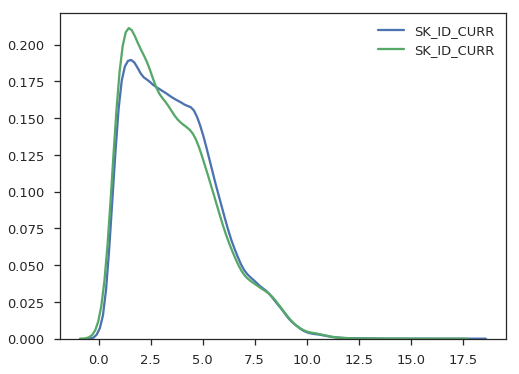

In [92]:
plt.figure(figsize=(8, 6))
sns.kdeplot(res[app_train.TARGET == 0])
sns.kdeplot(res[app_train.TARGET == 1]);

In [93]:
res = tmp.groupby('SK_ID_CURR')['mult_ratio_annuity_days_decision'].max()
res = app_train.SK_ID_CURR.map(res)

print(res[res.isnull()].shape[0] / len(res))

0.06529197329526423


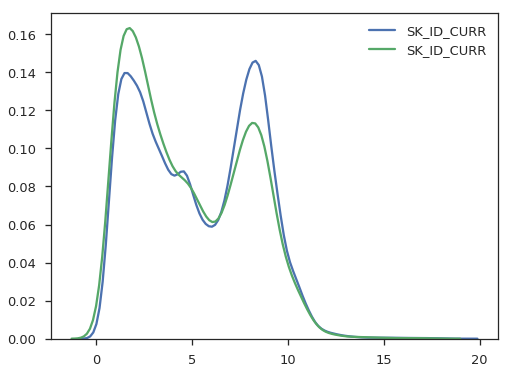

In [94]:
plt.figure(figsize=(8, 6))
sns.kdeplot(res[app_train.TARGET == 0])
sns.kdeplot(res[app_train.TARGET == 1]);

#### REGION_POPULATION_RELATIVE:	Normalized population of region where client lives (higher number means the client lives in more populated region)

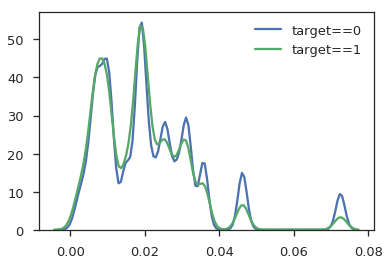

In [5]:
sns.kdeplot(app_train.loc[app_train.TARGET == 0, 'REGION_POPULATION_RELATIVE'], label='target==0')
sns.kdeplot(app_train.loc[app_train.TARGET == 1, 'REGION_POPULATION_RELATIVE'], label='target==1');

In [52]:
tmp = app_train.REGION_POPULATION_RELATIVE * (app_train.EXT_SOURCE_3)
tmp.head()

0    0.002621
1         NaN
2    0.007320
3         NaN
4         NaN
dtype: float16

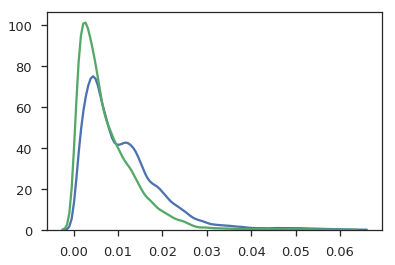

In [53]:
sns.kdeplot(tmp[(app_train.TARGET == 0)])
sns.kdeplot(tmp[(app_train.TARGET == 1)]);

#### Relationship between previous application annuity and installments

In [10]:
# positive

installments.loc[(installments.SK_ID_CURR == 107188) &\
                 (installments.SK_ID_PREV == 1830238)
                ].sort_values(by=['NUM_INSTALMENT_NUMBER', 'NUM_INSTALMENT_VERSION'])

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
3050310,1830238,107188,1.0,1,-367.0,-379.0,6513.120117,6513.120117
2290580,1830238,107188,1.0,2,-337.0,-350.0,6513.120117,6513.120117
2907257,1830238,107188,1.0,3,-307.0,-319.0,6513.120117,6513.120117
158335,1830238,107188,1.0,4,-277.0,-290.0,6513.120117,6513.120117
381633,1830238,107188,1.0,5,-247.0,-264.0,6513.120117,6513.120117
2932710,1830238,107188,1.0,6,-217.0,-233.0,6513.120117,6513.120117
1244001,1830238,107188,1.0,7,-187.0,-208.0,6513.120117,6513.120117
2876745,1830238,107188,1.0,8,-157.0,-173.0,6513.120117,6513.120117
1384382,1830238,107188,1.0,9,-127.0,-140.0,6513.120117,6513.120117
1308135,1830238,107188,1.0,10,-97.0,-98.0,6512.040039,6512.040039


In [11]:
# negative

installments.loc[(installments.SK_ID_CURR == 383477) &\
                 (installments.SK_ID_PREV == 1448748)
                ].sort_values(by=['NUM_INSTALMENT_NUMBER', 'NUM_INSTALMENT_VERSION'])

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
8625889,1448748,383477,1.0,1,-479.0,-492.0,25620.525391,25620.525391
8713062,1448748,383477,1.0,2,-449.0,-463.0,25620.525391,25620.525391
9945420,1448748,383477,1.0,3,-419.0,-430.0,25620.525391,25620.525391
7958897,1448748,383477,1.0,4,-389.0,-401.0,25620.525391,25620.525391
11393452,1448748,383477,1.0,5,-359.0,-369.0,25620.525391,25620.525391
8514598,1448748,383477,1.0,6,-329.0,-338.0,25620.525391,25620.525391
8691708,1448748,383477,1.0,7,-299.0,-307.0,25620.525391,25620.525391
9422635,1448748,383477,1.0,8,-269.0,-277.0,25620.525391,25620.525391
9809357,1448748,383477,1.0,9,-239.0,-252.0,25620.525391,25620.525391
7849711,1448748,383477,1.0,10,-209.0,-223.0,25620.525391,25620.525391


In [13]:
t = installments.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['NUM_INSTALMENT_NUMBER'].max()
t = prev_app.loc[:, ['SK_ID_CURR', 'SK_ID_PREV', 'CNT_PAYMENT']]\
        .merge(t, how='left')

In [27]:
r = t.NUM_INSTALMENT_NUMBER.div(t.CNT_PAYMENT, fill_value=0).replace([np.inf, -np.inf], np.nan)
r = r.groupby(t.SK_ID_CURR).mean()

r = app_train.SK_ID_CURR.map(r)

print(r[r.isnull()].shape[0] / len(r))

0.06160755225016341


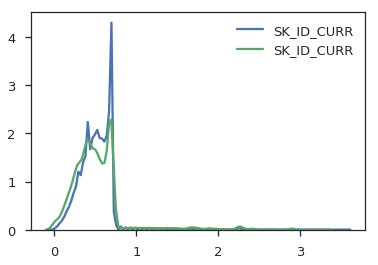

In [28]:
sns.kdeplot(r[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(r[app_train.TARGET == 1].map(np.log1p));

In [49]:
t = installments.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False).agg({
    'NUM_INSTALMENT_NUMBER': np.max,
    'AMT_PAYMENT': np.sum
})

t = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT', 'CNT_PAYMENT']]\
            .merge(t, how='left')

In [76]:
# r = (t.AMT_PAYMENT - t.AMT_CREDIT) * (t.CNT_PAYMENT - t.NUM_INSTALMENT_NUMBER)
# r = r.groupby(t.SK_ID_CURR).mean()

# r = app_train.SK_ID_CURR.map(r)
# print(r[r.isnull()].shape[0] / len(r))

mask = t.AMT_PAYMENT > t.AMT_CREDIT
r = (t[mask].AMT_PAYMENT - t[mask].AMT_CREDIT) * (t.CNT_PAYMENT)
r = r.groupby(t.SK_ID_CURR).min()

r = app_train.SK_ID_CURR.map(r)
print(r[r.isnull()].shape[0] / len(r))

0.10228577189108683


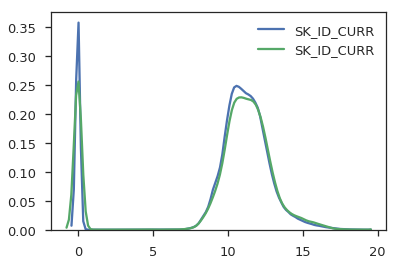

In [77]:
sns.kdeplot(r[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(r[app_train.TARGET == 1].map(np.log1p));